# Estimating speed of light from Newcomb's experiment - normal data with non-informative prior
From Gelman et. al Chapter 3.2

*Simon Newcomb set up an experiment in 1882 to measure the speed of light. Newcomb measured the amount of time required for light to travel a distance of 7442 meters. (...) There are two unusually low measurements and then a cluster of measurements that are approximately symmetrically distributed. We (inappropriately) apply the normal model, assuming that all 66 measurements are independent draws from a normal distribution with mean $\mu$ and variance $\sigma$. The main substantive goal is posterior inference for $\mu$. The mean of the 66 measurements is $\bar{y} = 26.2$, and the sample standard deviation is $s = 10.8$. Assuming the noninformative prior distribution $p(\mu, \sigma^2) \propto \sigma^{-2}$, a 95% central posterior interval for $\mu$ is obtained from the $t_{65}$ marginal posterior distribution of $\mu$ as $\bar{y} \pm 1.997s/\sqrt{66} = [23.6, 28.8]$.*

It should be noted, that data are recorded as deviations from 24,800 ns.

We will compare these results with a stan model

In [1]:
import sys
sys.path.append('../../Utilities')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd
import string

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

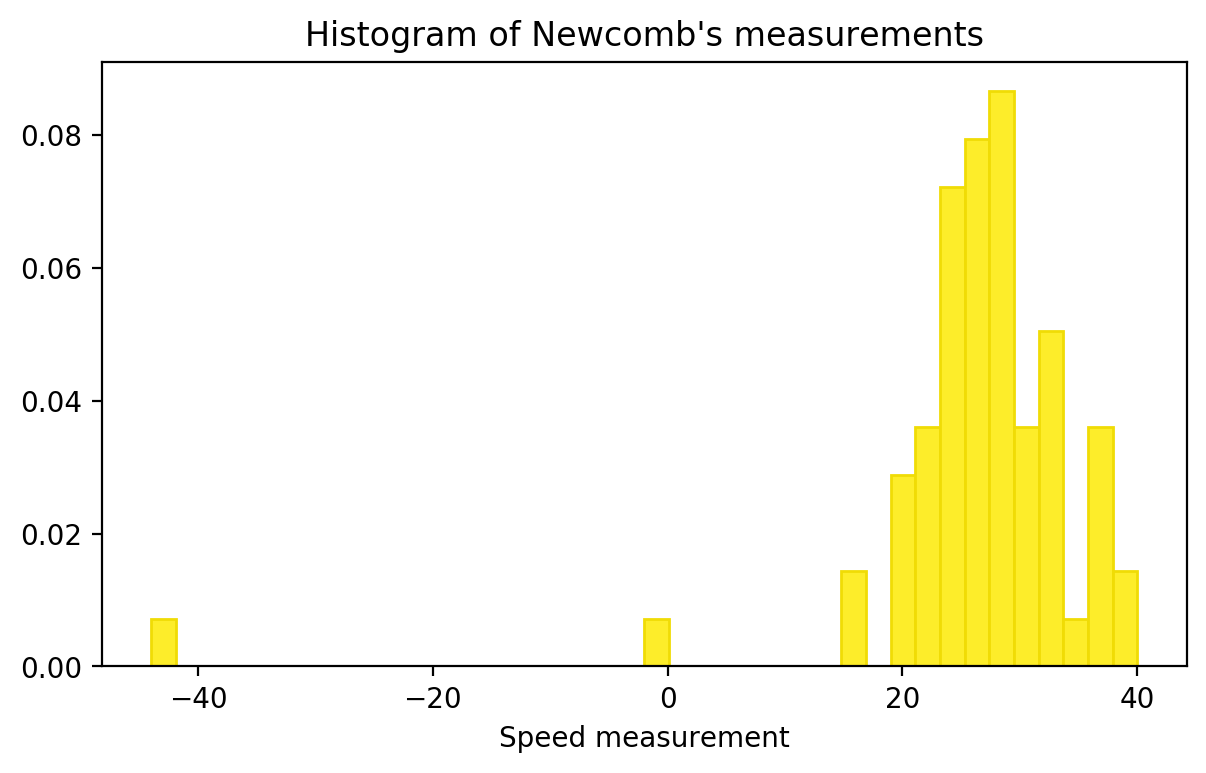

In [3]:
df=pd.read_table('light.txt',header=None,names=['V'])
V=df.V.to_numpy()
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(V,bins=40,color=mid,edgecolor=mid_highlight,density=True)
plt.xlabel('Speed measurement')
plt.title(str("Histogram of Newcomb's measurements"))
plt.show(ax)

In [4]:
model=stan_utility.compile_model('newcomb_fit_1.stan')

Using cached StanModel


In [5]:
with open('newcomb_fit_1.stan', 'r') as file:
    print(file.read())

data {
  int N; //number of samples
  real y[N];//measurements
}

parameters {
  real<lower=0> sigma;
  real mu;
}

model {
  target+=-2*log(sigma);
  target+=normal_lpdf(y|mu,sigma);
}

generated quantities {
    vector[N] log_lik;
    real mu_hat;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    mu_hat = normal_rng(mu,sigma);
}



In [6]:
data = dict(N = len(V),y = V)

In [7]:
fit = model.sampling(data = data,seed = 27042020)

In [8]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [9]:
params = fit.extract()

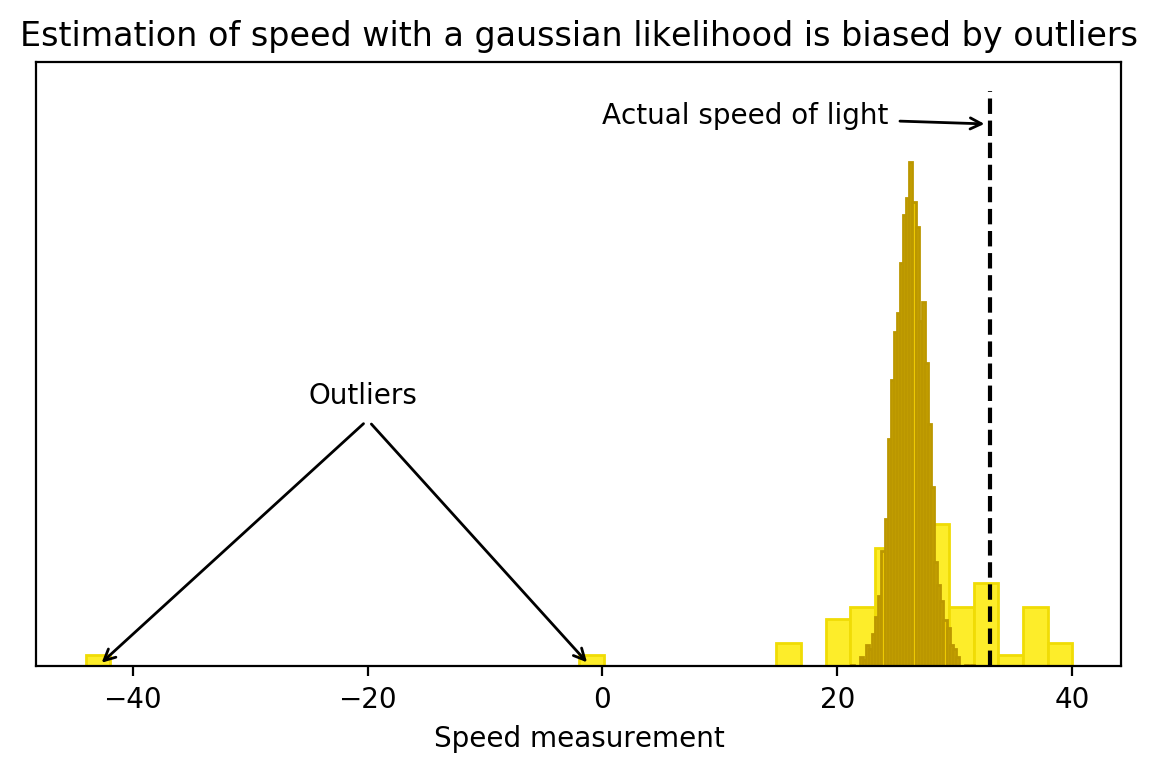

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(V,bins=40,color=mid,edgecolor=mid_highlight,density=True)
ax.hist(params['mu'],bins=40,color=dark,edgecolor=dark_highlight,density=True)
ax.plot([33,33],[0,0.35],color='black',linestyle='--')
ax.annotate('',xy=(-43,0),xytext=(-20, 0.15),arrowprops={'arrowstyle':'->'})
ax.annotate('',xy=(-1,0),xytext=(-20, 0.15),arrowprops={'arrowstyle':'->'})
ax.text(x=-25,y=0.16,s='Outliers')
ax.annotate('Actual speed of light',xy=(33,0.33),xytext=(0, 0.33),arrowprops={'arrowstyle':'->'})
ax.set_yticks([])
ax.set_title('Estimation of speed with a gaussian likelihood is biased by outliers')
plt.xlabel('Speed measurement')
plt.show(ax)

In [11]:
print('Mean: {:4.2f}'.format(np.mean(params['mu'])))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hpd(params['mu'],.95)])

Mean: 26.20
95% confidence interval:  ['23.56', '28.87']


Actual speed of light in this data scale is 33. Two outliers at -44 and -2 are certainly skewing our estimate. We can try to improve our estimate with more robust Student t model.

## Robust inference with Student-t likelihood
Student-t model is characterized by three parameters:
- $\nu$ - degrees of freedom
- $\mu$ - location
- $\sigma$ - scale

Degrees of freedom control the thickness of distribution tails, providing robustness to outlier, especially those that are hard to detect.

### Prior selection

Priors for location and scale are similar to the ones for mean and standard deviation in case of normal distribution. Degrees of freedom are either fixed as a design choice, or following "[Prior choice recommendation](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)" page at [Stan Wiki](https://github.com/stan-dev/stan/wiki/) we use non-informative prior:
$$
p(\nu)=\mathrm{Gamma}(2,0.1)
$$


In [12]:
with open('newcomb_fit_2.stan', 'r') as file:
    print(file.read())

data {
  int N; //number of samples
  real y[N];//measurements
}

parameters {
  real<lower=0> sigma;
  real mu;
  real<lower = 0> nu;
}

model {
  target+=-2*log(sigma);
  target+=gamma_lpdf(nu|2,0.1);
  target+=student_t_lpdf(y|nu,mu,sigma);
}

generated quantities {
    vector[N] log_lik;
    real mu_hat;
    for (j in 1:N) {
        log_lik[j] = student_t_lpdf(y[j]|nu,mu,sigma);
    }
    mu_hat = student_t_rng(nu,mu,sigma);
}



In [13]:
model2=stan_utility.compile_model('newcomb_fit_2.stan')

Using cached StanModel


In [14]:
fit2 = model2.sampling(data = data,seed = 27042020)

In [15]:
stan_utility.check_all_diagnostics(fit2)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [16]:
params2=fit2.extract()

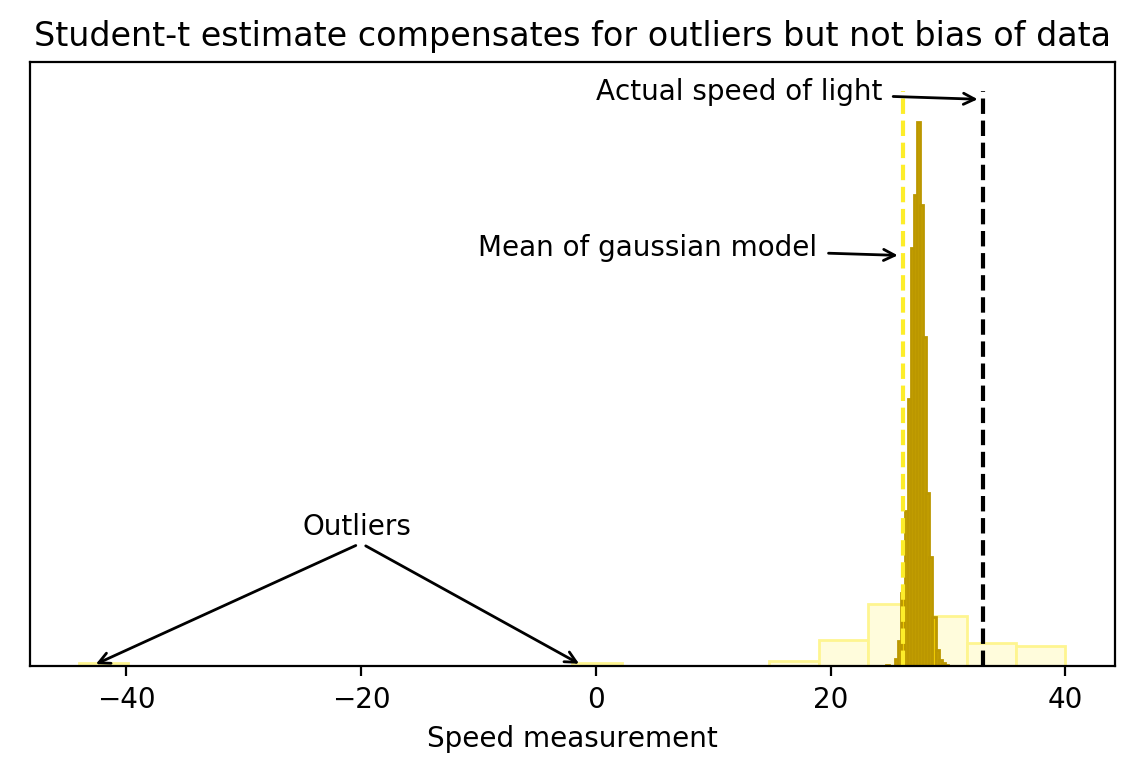

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
gm=np.mean(params['mu'])
ax.hist(V,bins=20,color=light,edgecolor=light_highlight,density=True)
ax.hist(params2['mu'],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.plot([33,33],[0,0.7],color='black',linestyle='--')
ax.plot([gm,gm],[0,0.7],color=mid,linestyle='--')
ax.annotate('Actual speed of light',xy=(33,0.69),xytext=(0, 0.69),arrowprops={'arrowstyle':'->'})
ax.annotate('Mean of gaussian model',xy=(gm,0.5),xytext=(-10, 0.5),arrowprops={'arrowstyle':'->'})
ax.annotate('',xy=(-43,0),xytext=(-20, 0.15),arrowprops={'arrowstyle':'->'})
ax.annotate('',xy=(-1,0),xytext=(-20, 0.15),arrowprops={'arrowstyle':'->'})
ax.text(x=-25,y=0.16,s='Outliers')
ax.set_yticks([])
ax.set_xlabel('Speed measurement')
ax.set_title('Student-t estimate compensates for outliers but not bias of data')
plt.show(ax)

In [18]:
print('Mean: {:4.2f}'.format(np.mean(params2['mu'])))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hpd(params2['mu'],.9)])

Mean: 27.42
95% confidence interval:  ['26.35', '28.42']


We got a much tighter estimate and mean moves in right direction, but is still biased. There are limitation of what you can do with bad data.